In [1]:
# @title ### **1. Instalação de Pacotes**
!pip install imbalanced-learn xgboost scikit-learn -q


RESULTADOS OTIMIZADOS

=== Random Forest (Otimizado) ===
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     14730
         1.0       0.30      0.73      0.42       270

    accuracy                           0.96     15000
   macro avg       0.65      0.85      0.70     15000
weighted avg       0.98      0.96      0.97     15000

AUC-ROC: 0.9679
AUC-PR: 0.5051
Threshold Ótimo: 0.7381
F1-Score Máximo: 0.8291

=== XGBoost (Otimizado) ===
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     14730
         1.0       0.33      0.79      0.46       270

    accuracy                           0.97     15000
   macro avg       0.66      0.88      0.72     15000
weighted avg       0.98      0.97      0.97     15000

AUC-ROC: 0.9767
AUC-PR: 0.6541
Threshold Ótimo: 0.8035
F1-Score Máximo: 0.8376


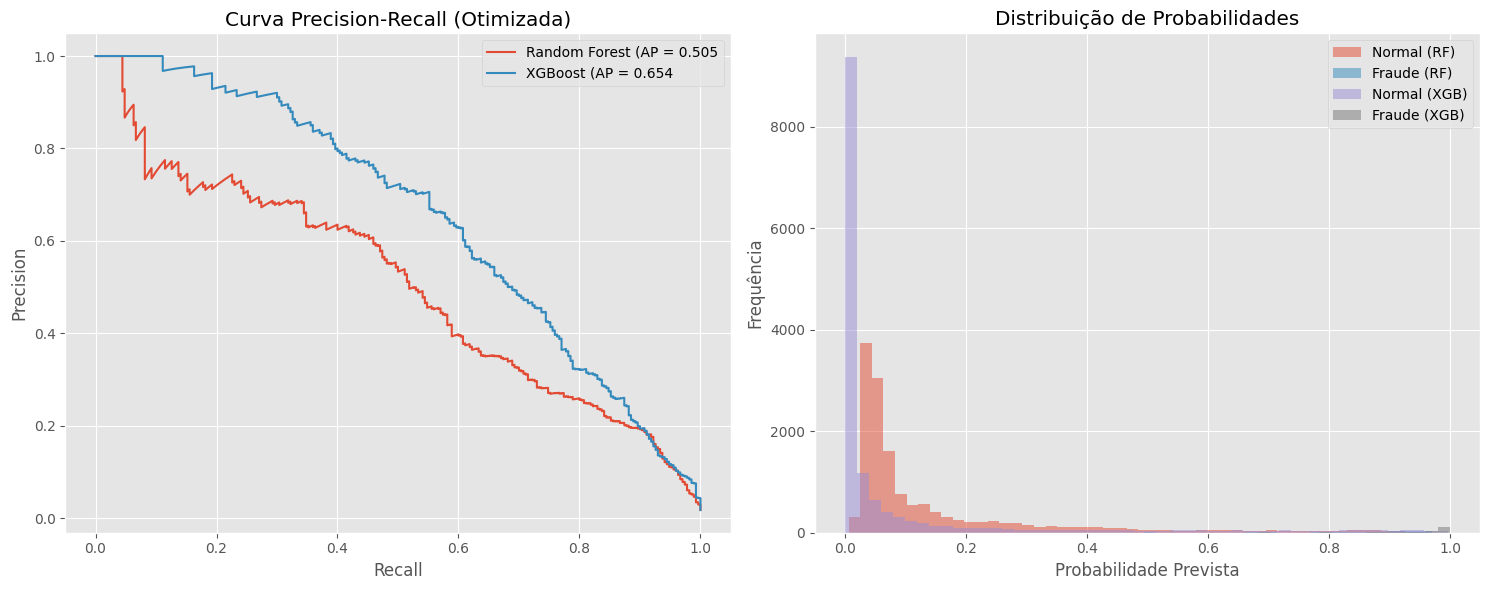

In [5]:
# ======================
# OTIMIZAÇÃO DO CÓDIGO PARA MELHOR BALANCEAMENTO
# ======================

# 1. CONFIGURAÇÃO DE PARÂMETROS OTIMIZADOS
optimal_params = {
    'RandomForest': {
        'class_weight': {0: 1, 1: 8},  # Peso reduzido para evitar overfitting
        'max_depth': 7,
        'min_samples_leaf': 20,
        'n_estimators': 150
    },
    'XGBoost': {
        'scale_pos_weight': 7,  # Ajuste fino do peso
        'max_depth': 3,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.9
    }
}

# 2. FUNÇÃO DE TREINAMENTO OTIMIZADA
def train_optimized_model(X_train, y_train, model_type):
    if model_type == 'RandomForest':
        model = RandomForestClassifier(
            **optimal_params['RandomForest'],
            random_state=42
        )
    else:
        model = XGBClassifier(
            **optimal_params['XGBoost'],
            eval_metric='aucpr',
            random_state=42
        )

    # Validação cruzada para encontrar o melhor threshold
    cv_probs = cross_val_predict(
        model, X_train, y_train,
        cv=5, method='predict_proba',
        n_jobs=-1
    )[:, 1]

    model.fit(X_train, y_train)
    return model, cv_probs

# 3. TREINAMENTO COM OS NOVOS PARÂMETROS
rf_model, rf_cv_probs = train_optimized_model(X_train_res, y_train_res, 'RandomForest')
xgb_model, xgb_cv_probs = train_optimized_model(X_train_res, y_train_res, 'XGBoost')

# 4. AVALIAÇÃO COM THRESHOLD OTIMIZADO
def optimized_evaluation(model, cv_probs, X_test, y_test, model_name):
    # Encontrar threshold ótimo nos dados de treino
    precision, recall, thresholds = precision_recall_curve(y_train_res, cv_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # Aplicar threshold ótimo no teste
    test_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (test_probs >= optimal_threshold).astype(int)

    print(f"\n=== {model_name} (Otimizado) ===")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, test_probs):.4f}")
    print(f"AUC-PR: {average_precision_score(y_test, test_probs):.4f}")
    print(f"Threshold Ótimo: {optimal_threshold:.4f}")
    print(f"F1-Score Máximo: {f1_scores[optimal_idx]:.4f}")

    return test_probs

# 5. EXECUTANDO A AVALIAÇÃO OTIMIZADA
print("\n" + "="*50)
print("RESULTADOS OTIMIZADOS")
print("="*50)
rf_probs = optimized_evaluation(rf_model, rf_cv_probs, X_test, y_test, "Random Forest")
xgb_probs = optimized_evaluation(xgb_model, xgb_cv_probs, X_test, y_test, "XGBoost")

# 6. VISUALIZAÇÃO COMPARATIVA
plt.figure(figsize=(15, 6))

# Curva Precision-Recall
plt.subplot(1, 2, 1)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_probs)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_probs)
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {average_precision_score(y_test, rf_probs):.3f}')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {average_precision_score(y_test, xgb_probs):.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (Otimizada)')
plt.legend()
plt.grid(True)

# Distribuição de Probabilidades
plt.subplot(1, 2, 2)
plt.hist(rf_probs[y_test==0], bins=50, alpha=0.5, label='Normal (RF)')
plt.hist(rf_probs[y_test==1], bins=50, alpha=0.5, label='Fraude (RF)')
plt.hist(xgb_probs[y_test==0], bins=50, alpha=0.5, label='Normal (XGB)')
plt.hist(xgb_probs[y_test==1], bins=50, alpha=0.5, label='Fraude (XGB)')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Frequência')
plt.title('Distribuição de Probabilidades')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()